In [1]:
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split

%matplotlib inline
pd.set_option("display.mpl_style", "default")

https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis

In [2]:
train = pd.read_csv("data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("data/testData.tsv", header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv("data/unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

# Verify the number of reviews that were read (100,000 in total)
print "Read %d labeled train reviews, %d labeled test reviews, and %d unlabeled reviews\n" % (train["review"].size, test["review"].size, unlabeled_train["review"].size )

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [3]:
X = train["review"]
y = train["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
#Do some very minor text preprocessing
def clean_text(corpus):
    punctuation = """.,?!:;(){}[]"""
    corpus = [z.lower().replace('\n','') for z in corpus]
    corpus = [z.replace('<br />', ' ') for z in corpus]

    #treat punctuation as individual words
    for c in punctuation:
        corpus = [z.replace(c, ' %s '%c) for z in corpus]
    corpus = [z.split() for z in corpus]

    return corpus

In [5]:
X_train = clean_text(X_train)
X_test = clean_text(X_test)

In [6]:
#Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
#We do this by using the LabeledSentence method. The format will be "TRAIN_i" or "TEST_i" where "i" is
#a dummy index of the review.
def labelize_reviews(reviews, label_type):
    labelized = []
    for i,v in enumerate(reviews):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))

    return labelized

In [7]:
X_train = labelize_reviews(X_train, 'TRAIN')
X_test = labelize_reviews(X_test, 'TEST')

In [8]:
print len(X_train)
print len(X_test)
X_train[0]

17500
7500


In [9]:
%%time
size = 300

# instantiate our DM and DBOW models
model_dm = Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, workers=4)
model_dbow = Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, dm=0, workers=4)

# build vocab over reviews
model_dm.build_vocab(np.concatenate((X_train, X_test)))
model_dbow.build_vocab(np.concatenate((X_train, X_test)))

CPU times: user 1min 16s, sys: 959 ms, total: 1min 16s
Wall time: 1min 19s


In [16]:
# results from untrained doc2vec model
model_dm.most_similar("queen", topn=5)

[('yakima', 0.24716466665267944),
 ('rowlands', 0.24246005713939667),
 ('TRAIN_9140', 0.23961135745048523),
 ("dorsey's", 0.22907492518424988),
 ('locals--especially', 0.22821496427059174),
 ('redirected', 0.2251446545124054),
 ('teutonic', 0.22266051173210144),
 ('nilsson', 0.2225494682788849),
 ('weighed', 0.2212829887866974),
 ('*cough*the', 0.21922147274017334)]

In [10]:
%%time
# We pass through the data set multiple times, shuffling the training reviews each time to improve accuracy.
# This could take a while.

all_train_reviews = np.concatenate((X_train, X_test))
for epoch in range(10):
    perm = np.random.permutation(all_train_reviews.shape[0])
    model_dm.train(all_train_reviews[perm])
    model_dbow.train(all_train_reviews[perm])

CPU times: user 23min 15s, sys: 5min 24s, total: 28min 40s
Wall time: 40min 3s


In [31]:
# results from trained doc2vec model
model_dm.most_similar("queen", topn=5)

[("'mask", 0.26882144808769226),
 ('granddaughter', 0.2560391128063202),
 ('carapace', 0.25589966773986816),
 ('queens', 0.2532525062561035),
 ('boink', 0.24644553661346436)]

#### Checkpoint

In [48]:
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model_dm.init_sims(replace=True)

In [12]:
model_dm.save("model/dm_300features_10context_10epochs")
model_dbow.save("model/dbow_300features_10context_10epochs")

### Use Doc Vectors As Features for Classifiers

In [215]:
model_dm = Doc2Vec.load("model/dm_300features_10context_10epochs")
model_dbow = Doc2Vec.load("model/dbow_300features_10context_10epochs")

In [15]:
#Get vectors from our models
def get_vecs(model, corpus, size):
    vecs = [np.array(model[review.labels[0]]).reshape((1, size)) for review in corpus]

    return np.concatenate(vecs)

#### Only Use DM Vectors (AUC 92%)

In [16]:
size = 300

#Construct vectors for training and test reviews
train_vecs = get_vecs(model_dm, X_train, size)
test_vecs = get_vecs(model_dm, X_test, size)

In [17]:
print len(train_vecs), len(X_train)
print len(test_vecs), len(X_test)

17500 17500
7500 7500


#### Optional: Only Use DBOW Vectors (AUC 94%)

In [28]:
size = 300

#Construct vectors for training and test reviews
train_vecs = get_vecs(model_dbow, X_train, size)
test_vecs = get_vecs(model_dbow, X_test, size)

#### Optional: Use Combined DM and DBOW Vectors (AUC 93%)

In [23]:
size = 300

#Construct vectors for training and test reviews
train_vecs_dm = get_vecs(model_dm, X_train, size)
train_vecs_dbow = get_vecs(model_dbow, X_train, size)
train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))

test_vecs_dm = get_vecs(model_dm, X_test, size)
test_vecs_dbow = get_vecs(model_dbow, X_test, size)
test_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))

### Initialize Our Classifier

In [29]:
clf = SGDClassifier(loss='log', penalty='l1')
clf.fit(train_vecs, y_train)

print 'Test Accuracy: %.2f'% clf.score(test_vecs, y_test)

Test Accuracy: 0.87


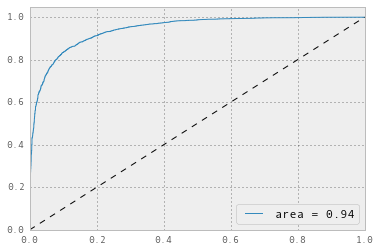

In [30]:
pred_probas = clf.predict_proba(test_vecs)[:,1]

fpr,tpr,_ = roc_curve(y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()